In [1]:
from preprocessor import Preprocessor
from batch_generator import BatchGenerator
from modelling import Mothership
from keras.optimizers import Adam

Using TensorFlow backend.


In [36]:
batch_generator = BatchGenerator(64, 64)

In [37]:
batch_generator[0][0][0].shape, batch_generator[0][0][1].shape

((128, 10), (128, 10))

In [5]:
# model = Mothership(15, [102, 42], 16, [102, 102, 42], 10, [2, 2], [2, 2, 2])
model = Mothership(10, [], 10, [], 10, [], [])

In [38]:
model.compile(Adam(lr=.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [39]:
model.fit_generator(batch_generator, epochs=1)

Epoch 1/1


208/767 [=======>......................] - ETA: 4:26 - loss: 0.6837 - acc: 0.601 - ETA: 1:14 - loss: 0.6037 - acc: 0.681 - ETA: 1:14 - loss: 0.6194 - acc: 0.657 - ETA: 1:15 - loss: 0.6241 - acc: 0.654 - ETA: 1:15 - loss: 0.6231 - acc: 0.652 - ETA: 1:15 - loss: 0.6260 - acc: 0.648 - ETA: 1:15 - loss: 0.6369 - acc: 0.633 - ETA: 1:15 - loss: 0.6315 - acc: 0.637 - ETA: 1:15 - loss: 0.6290 - acc: 0.637 - ETA: 1:15 - loss: 0.6259 - acc: 0.637 - ETA: 1:15 - loss: 0.6303 - acc: 0.632 - ETA: 1:15 - loss: 0.6319 - acc: 0.628 - ETA: 1:15 - loss: 0.6253 - acc: 0.635 - ETA: 1:15 - loss: 0.6232 - acc: 0.638 - ETA: 1:15 - loss: 0.6214 - acc: 0.640 - ETA: 1:15 - loss: 0.6190 - acc: 0.643 - ETA: 1:15 - loss: 0.6180 - acc: 0.644 - ETA: 1:15 - loss: 0.6129 - acc: 0.648 - ETA: 1:15 - loss: 0.6091 - acc: 0.651 - ETA: 1:15 - loss: 0.6094 - acc: 0.653 - ETA: 1:15 - loss: 0.6088 - acc: 0.654 - ETA: 1:15 - loss: 0.6070 - acc: 0.655 - ETA: 1:15 - loss: 0.6078 - acc: 0.653 - ETA: 1:15 - loss: 0.6088 - acc: 0.652

423/767 [===============>..............] - ETA: 57s - loss: 0.5995 - acc: 0.67 - ETA: 57s - loss: 0.5995 - acc: 0.67 - ETA: 57s - loss: 0.5994 - acc: 0.67 - ETA: 57s - loss: 0.5997 - acc: 0.67 - ETA: 57s - loss: 0.5996 - acc: 0.67 - ETA: 57s - loss: 0.6001 - acc: 0.66 - ETA: 57s - loss: 0.6001 - acc: 0.66 - ETA: 57s - loss: 0.6003 - acc: 0.66 - ETA: 57s - loss: 0.6000 - acc: 0.67 - ETA: 56s - loss: 0.5997 - acc: 0.67 - ETA: 56s - loss: 0.5996 - acc: 0.67 - ETA: 56s - loss: 0.6000 - acc: 0.67 - ETA: 56s - loss: 0.5998 - acc: 0.67 - ETA: 56s - loss: 0.6000 - acc: 0.67 - ETA: 56s - loss: 0.5998 - acc: 0.67 - ETA: 56s - loss: 0.5996 - acc: 0.67 - ETA: 56s - loss: 0.5994 - acc: 0.67 - ETA: 56s - loss: 0.5995 - acc: 0.67 - ETA: 55s - loss: 0.5997 - acc: 0.67 - ETA: 55s - loss: 0.5999 - acc: 0.67 - ETA: 55s - loss: 0.5998 - acc: 0.67 - ETA: 55s - loss: 0.5998 - acc: 0.67 - ETA: 55s - loss: 0.5995 - acc: 0.67 - ETA: 55s - loss: 0.5994 - acc: 0.67 - ETA: 55s - loss: 0.5987 - acc: 0.67 - ETA: 55

638/767 [=======================>......] - ETA: 35s - loss: 0.5987 - acc: 0.66 - ETA: 35s - loss: 0.5986 - acc: 0.67 - ETA: 35s - loss: 0.5985 - acc: 0.67 - ETA: 35s - loss: 0.5987 - acc: 0.67 - ETA: 35s - loss: 0.5989 - acc: 0.66 - ETA: 35s - loss: 0.5988 - acc: 0.66 - ETA: 34s - loss: 0.5989 - acc: 0.66 - ETA: 34s - loss: 0.5989 - acc: 0.66 - ETA: 34s - loss: 0.5989 - acc: 0.66 - ETA: 34s - loss: 0.5989 - acc: 0.66 - ETA: 34s - loss: 0.5991 - acc: 0.66 - ETA: 34s - loss: 0.5991 - acc: 0.66 - ETA: 34s - loss: 0.5991 - acc: 0.66 - ETA: 34s - loss: 0.5989 - acc: 0.66 - ETA: 34s - loss: 0.5990 - acc: 0.66 - ETA: 34s - loss: 0.5989 - acc: 0.66 - ETA: 33s - loss: 0.5989 - acc: 0.66 - ETA: 33s - loss: 0.5988 - acc: 0.66 - ETA: 33s - loss: 0.5986 - acc: 0.66 - ETA: 33s - loss: 0.5985 - acc: 0.66 - ETA: 33s - loss: 0.5986 - acc: 0.66 - ETA: 33s - loss: 0.5986 - acc: 0.66 - ETA: 33s - loss: 0.5985 - acc: 0.66 - ETA: 33s - loss: 0.5985 - acc: 0.66 - ETA: 33s - loss: 0.5986 - acc: 0.66 - ETA: 32

767/767 [==============================] - ETA: 13s - loss: 0.5987 - acc: 0.67 - ETA: 13s - loss: 0.5989 - acc: 0.67 - ETA: 13s - loss: 0.5990 - acc: 0.67 - ETA: 12s - loss: 0.5990 - acc: 0.67 - ETA: 12s - loss: 0.5988 - acc: 0.67 - ETA: 12s - loss: 0.5988 - acc: 0.67 - ETA: 12s - loss: 0.5987 - acc: 0.67 - ETA: 12s - loss: 0.5988 - acc: 0.67 - ETA: 12s - loss: 0.5988 - acc: 0.67 - ETA: 12s - loss: 0.5988 - acc: 0.67 - ETA: 12s - loss: 0.5988 - acc: 0.67 - ETA: 12s - loss: 0.5988 - acc: 0.67 - ETA: 12s - loss: 0.5988 - acc: 0.67 - ETA: 11s - loss: 0.5988 - acc: 0.67 - ETA: 11s - loss: 0.5989 - acc: 0.67 - ETA: 11s - loss: 0.5990 - acc: 0.67 - ETA: 11s - loss: 0.5990 - acc: 0.67 - ETA: 11s - loss: 0.5989 - acc: 0.67 - ETA: 11s - loss: 0.5990 - acc: 0.66 - ETA: 11s - loss: 0.5990 - acc: 0.66 - ETA: 11s - loss: 0.5991 - acc: 0.66 - ETA: 11s - loss: 0.5992 - acc: 0.66 - ETA: 10s - loss: 0.5991 - acc: 0.66 - ETA: 10s - loss: 0.5992 - acc: 0.66 - ETA: 10s - loss: 0.5991 - acc: 0.66 - ETA: 10

In [40]:
import sys

In [41]:
sys.path.append('../nikita')

In [42]:
from evaluating import permutation_importance

In [43]:
batch_generator = BatchGenerator(1024, 1024)

In [44]:
import pickle

In [45]:
fn = {
  "que": [
#     "students_location",
#     "students_state",
#     "students_questions_asked",
#     "students_average_question_age",
#     "students_average_question_body_length",
#     "students_average_answer_body_length",
#     "students_date_joined_time",
#     "students_date_joined_doy_sin",
#     "students_date_joined_doy_cos",
#     "students_date_joined_dow",
#     "questions_body_length",
#     "questions_date_added_time",
#     "questions_date_added_doy_sin",
#     "questions_date_added_doy_cos",
#     "questions_date_added_dow",
#     "questions_date_added_hour_sin",
#     "questions_date_added_hour_cos",
#     "questions_current_time",
  ],
  "pro": [
#     "professionals_industry",
#     "professionals_location",
#     "professionals_state",
#     "professionals_questions_answered",
#     "professionals_average_question_age",
#     "professionals_average_question_body_length",
#     "professionals_average_answer_body_length",
#     "professionals_email_activated",
#     "professionals_date_joined_time",
#     "professionals_date_joined_doy_sin",
#     "professionals_date_joined_doy_cos",
#     "professionals_date_joined_dow",
#     "professionals_last_answer_date_time",
#     "professionals_current_time"
  ]
}

In [46]:
fn['que'] += [f'que_emb_{i}' for i in range(10)]

In [47]:
fn['pro'] += [f'pro_emb_{i}' for i in range(10)]

In [48]:
fn['text'] = [f'que_emb_{i}' for i in range(10)] + [f'pro_emb_{i}' for i in range(10)]

In [49]:
len(fn['que']), len(fn['pro'])

(10, 10)

In [50]:
batch_generator[0][0][0].shape, batch_generator[0][0][1].shape

((2048, 10), (2048, 10))

In [51]:
from jupyterthemes import jtplot
jtplot.style('gruvboxd')

In [52]:
import evaluating

In [53]:
import imp
imp.reload(evaluating)

<module 'evaluating' from 'C:\\Users\\dell\\Notebooks\\cv\\kostya\\evaluating.py'>

In [54]:
fi = evaluating.permutation_importance(model, batch_generator[0][0][0], batch_generator[0][0][1], batch_generator[0][1], fn)

2048/2048 [==============================] - ETA:  - ETA:  - 0s 68us/step


In [55]:
fi.sort_values(by='importance', ascending=False)

,importance
pro_emb_4,0.051256
pro_emb_5,0.035922
pro_emb_2,0.028637
pro_emb_8,0.023986
pro_emb_6,0.019153
que_emb_8,0.014115
que_emb_9,0.011166
que_emb_3,0.007691
que_emb_7,0.007307
pro_emb_9,0.006249


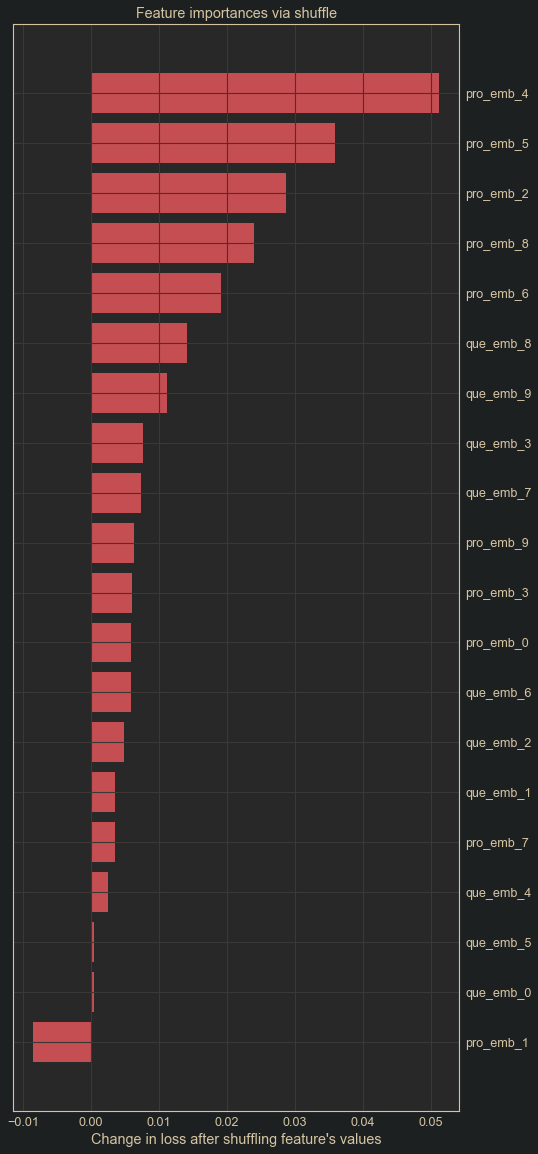

In [56]:
evaluating.plot_fi(fi, fn)